In [158]:
!pip install  category_encoders

In [159]:
! pip install xgboost

In [160]:
!pip install shap

In [161]:
import pandas as pd
import numpy as np
import pandas as pd
import string
import warnings
import missingno
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from category_encoders import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from random import randint

# 데이터 불러오기

In [162]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"seakwan121","key":"d2de9bd9c3acbdce6b128fa2b0791946"}'}

In [163]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         74           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         73           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        581           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        142           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1467           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      14628           False  
house-pr

In [164]:
! kaggle competitions download -c bike-sharing-demand

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [165]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submission = pd.read_csv('sampleSubmission.csv')
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)

In [166]:
df_all.shape

(17379, 12)

In [167]:
df_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


# EDA, 전처리

RMSLE 기반 예측을 위한 log 필드 추가

In [168]:
df_all['casual_log'] = np.log(df_all['casual'] + 1)
df_all['registered_log'] = np.log(df_all['registered'] + 1)
df_all['count_log'] = np.log(df_all['count'] + 1)

In [169]:
df_train.shape

(10886, 12)

In [170]:
df_test.shape

(6493, 9)

In [171]:
df_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_log,registered_log,count_log
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,1.386294,2.639057,2.833213
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,2.197225,3.496508,3.713572
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,1.791759,3.332205,3.496508
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,1.386294,2.397895,2.639057
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,0.000000,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,NaN,NaN,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,NaN,NaN,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,NaN,NaN,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,NaN,NaN,NaN


* datetime: 연-월-일 시:분:초
* season:
   - 1 = winter 
   - 2 = spring
   - 3 = summer
   - 4 = fall
* holiday: 해당 날짜(datetime)가 공휴일이었는지 여부(1은 공휴일)
   - 공휴일이 아닌, 일반적인 주말(일안하는 날)은 0으로 표기됨
* workingday: 해당 날짜(datetime)가 일하는 날(즉, 워킹데이, 공휴일 또는 주말이 아닌 날)인지 여부(1은 해당 날짜가 일하는 날임을 의미함)
* weather:
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp: 절대 온도 (화씨, C)
* atemp: 체감 온도 (화씨, C)
* humidity: 상대 습도
* windspeed: 풍속
* casual: 등록안한 사람의 대여 횟수
* registered: 등록자의 대여 횟수
* count: 총 대여 횟수 (casual + registered)

> train 은 매달 1일부터 19일까지, test 는 매달 20일부터, 마지막일까지를 가지고 있음

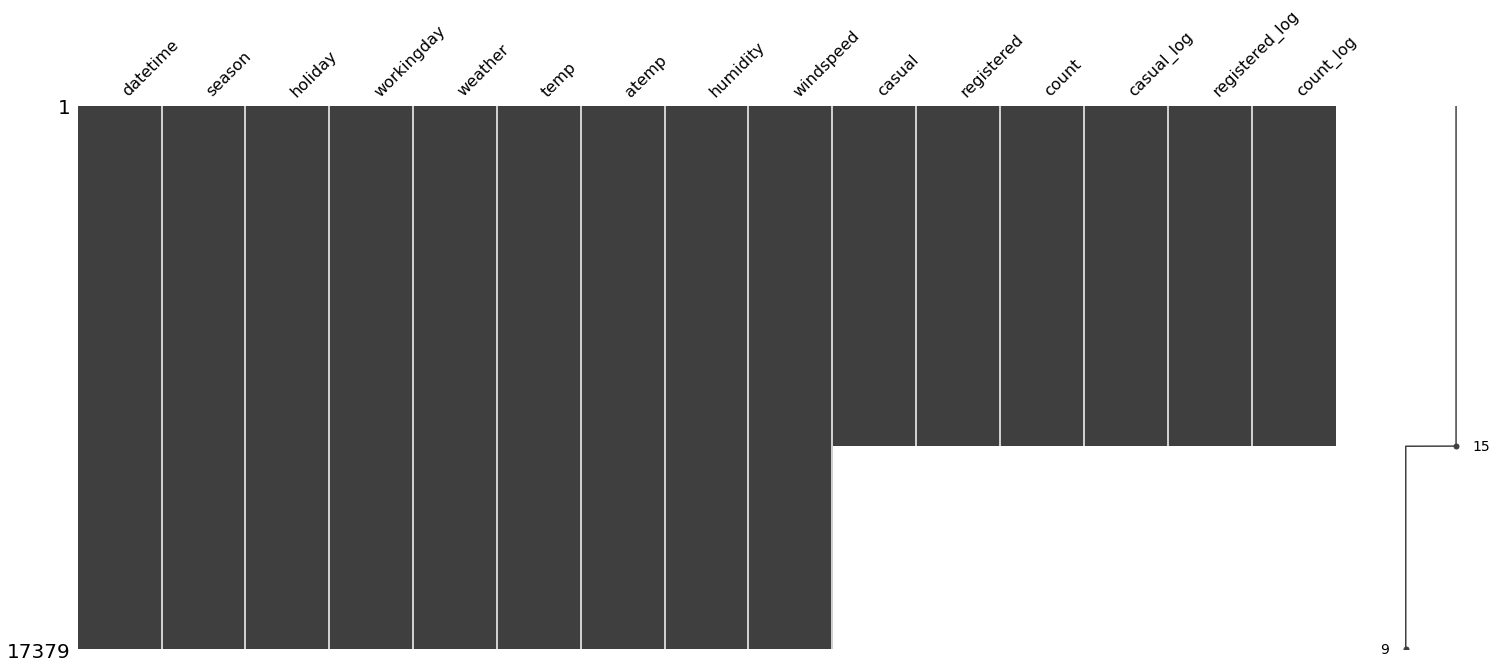

In [172]:
missingno.matrix(df_all)

**1 - 1 일 하는 날과 일을 하지 않는 날을 나눠 특정 날짜, 시간, 달, 년 등등 으로 비교 분석 할 수 있게 만듬**

In [173]:
dt = pd.DatetimeIndex(df_all['datetime'])
df_all.set_index(dt, inplace=True)

df_all['date'] = dt.date
df_all['day'] = dt.day
df_all['month'] = dt.month
df_all['year'] = dt.year
df_all['hour'] = dt.hour
df_all['dow'] = dt.dayofweek
df_all['woy'] = dt.weekofyear

In [174]:
df_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_log,registered_log,count_log,date,day,month,year,hour,dow,woy
datetime,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,1.386294,2.639057,2.833213,2011-01-01,1,1,2011,0,5,52
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2.197225,3.496508,3.713572,2011-01-01,1,1,2011,1,5,52
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,1.791759,3.332205,3.496508,2011-01-01,1,1,2011,2,5,52
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,1.386294,2.397895,2.639057,2011-01-01,1,1,2011,3,5,52
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,0.000000,0.693147,0.693147,2011-01-01,1,1,2011,4,5,52


In [175]:
def split_df(df):
    return df[:10885], df[10886:]

In [176]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_train, df_test = split_df(df_all)

def visualize(column_name):
    df_train_workingday_time = df_train.groupby(['workingday', column_name]).sum()
    df_train_workingday_time = df_train_workingday_time.reset_index()
    
    times_nonworkday = df_train_workingday_time[df_train_workingday_time['workingday'] == 0][column_name]
    counts_nonworkday = df_train_workingday_time[df_train_workingday_time['workingday'] == 0]['count']
    
    times_workday = df_train_workingday_time[df_train_workingday_time['workingday'] == 1][column_name]
    counts_workday = df_train_workingday_time[df_train_workingday_time['workingday'] == 1]['count']
    
    df_temp_workday = pd.concat([times_workday, counts_workday], axis=1, keys=[column_name, 'count'])
    df_temp_nonworkday = pd.concat([times_nonworkday, counts_nonworkday], axis=1, keys=[column_name, 'count'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=('workday', 'non-workday'))
    fig.add_trace(
        go.Bar(x=df_temp_workday[column_name], y=df_temp_workday['count'], text=df_temp_workday['count'],
              textposition='auto', texttemplate='%{text:.0f}'), row=1, col=1
    )
    fig.add_trace(
        go.Bar(x=df_temp_nonworkday[column_name], y=df_temp_nonworkday['count'], text=df_temp_nonworkday['count'],
              textposition='auto', texttemplate='%{text:.0f}'), row=1, col=2
    )
    fig.update_layout(showlegend=False)
    fig.show()

In [177]:
visualize('year')

- 연도별 자전거 대여 수 증가량 2011년에 비해 2012년에 확실히 많아 졌지만 다른 년도의 데이터가 없어 제대로 된 확인이 안됨
- 일하는 날과 일 하지 않는 날의 자전거 대여 수를 확인해보니 일 하는 날의 자전거 대여수가 훨씬 많다는 것이 확인됨

In [178]:
visualize('month')

- 추운 겨울에는 자전거 대여 수가 많이 줄어든 것을 알 수 있음

In [179]:
visualize('dow')

- 월요일은 0 ~ 일요일은 6
- 일하는 날에는 큰 차이가 보이지 않음
- 일하지 않는 날의 평일 데이터는 노이즈 데이터로 보임

In [180]:
visualize('woy')

- week of year 1년의 52주를 나타내는 그래프
- month 에서 확인 한 것과 같이 겨울에는 자전거를 빌리는 횟수가 적다는 것을 알 수 있음

In [181]:
df_train, df_test = split_df(df_all)
df_train_workingday_hour = df_train.groupby(['workingday', 'hour']).sum()
df_train_workingday_hour = df_train_workingday_hour.reset_index()

hours_nonworkday = df_train_workingday_hour[df_train_workingday_hour['workingday'] == 0]['hour']
counts_nonworkday = df_train_workingday_hour[df_train_workingday_hour['workingday'] == 0]['count']

hours_workday = df_train_workingday_hour[df_train_workingday_hour['workingday'] == 1]['hour']
counts_workday = df_train_workingday_hour[df_train_workingday_hour['workingday'] == 1]['count']

df_temp_workday = pd.concat([hours_workday, counts_workday], axis=1, keys=['hour', 'count'])
df_temp_nonworkday = pd.concat([hours_nonworkday, counts_nonworkday], axis=1, keys=['hour', 'count'])

In [182]:
fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_workday['hour'], y=df_temp_workday['count'], text=df_temp_workday['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({ 
        "title": { "text": "<b>workday</b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'ggplot2'            
})
fig.show()

fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_nonworkday['hour'], y=df_temp_nonworkday['count'], text=df_temp_nonworkday['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({
        "title": { "text": "<b>non-workday</b>" },
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'seaborn'            
})
fig.show()

- 하루 24시간을 나눈 시간 대 별 그래프
- 일 하는 날의 새벽에는 잘 빌리지 않는 것으로 보임
- 일하는 날의 출 퇴근 시간에 주로 자주 빌림
- 일하지 않는 날의 새벽에는 일 하는 날에 비해 많이 타는 것으로 보임
- 일하는 날의 피크 시간은 8시, 17 ~ 18시로 주로 출 퇴근 시간에 많이 빌리는 것으로 보임
- 일하지 않는 날의 피크 시간은 10~19시로 주로 낮에 빌리는 것으로 보임

**1 - 2 상관관계 분석**

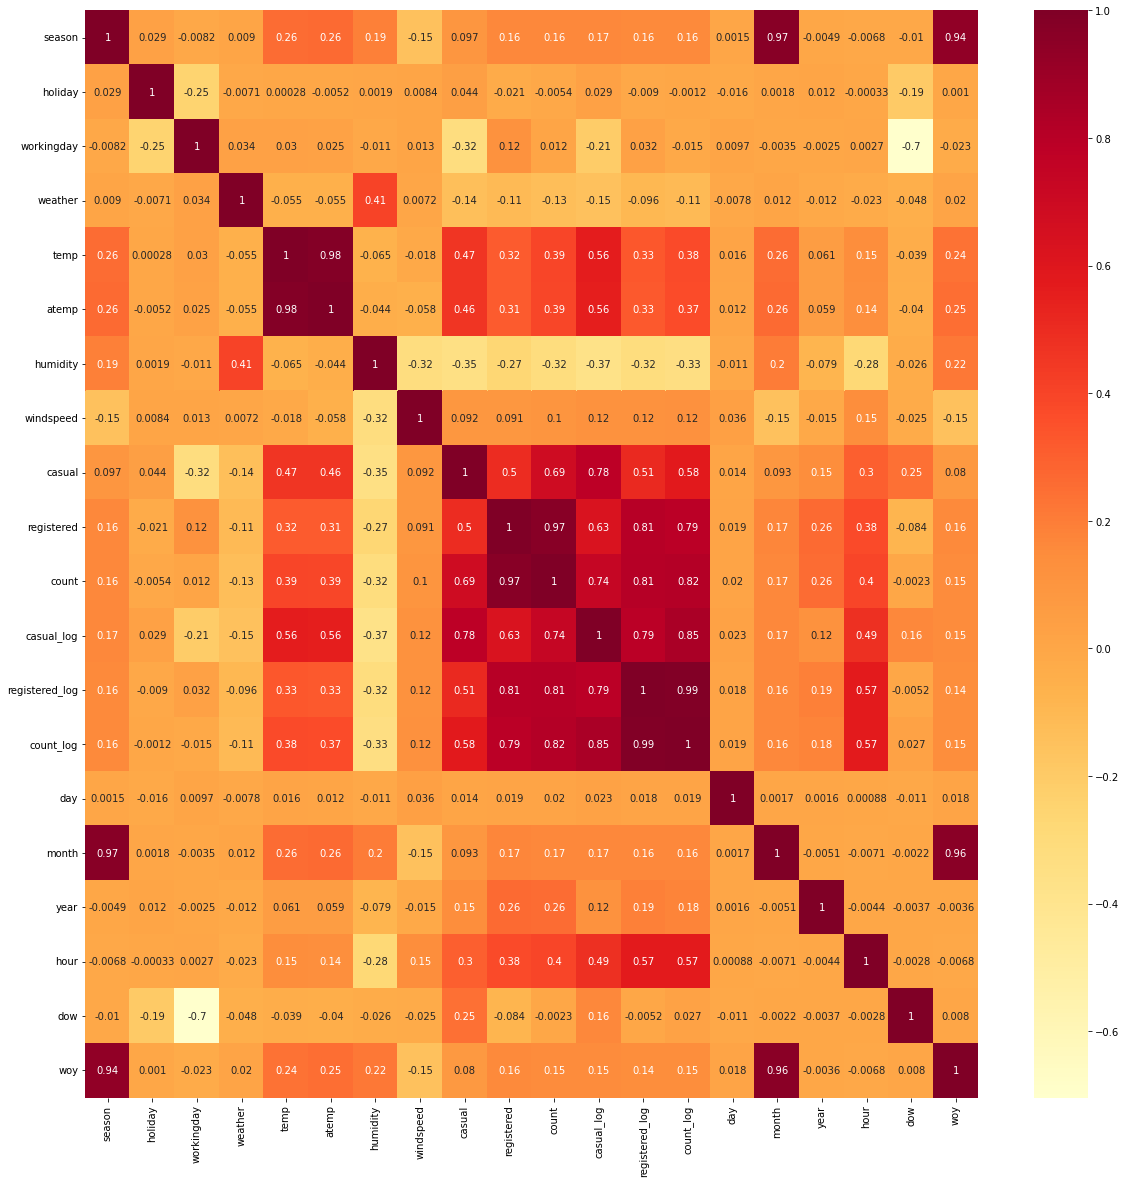

In [183]:
train_corr = df_train.corr()

plt.figure(figsize=(20,20))
sns.heatmap(train_corr, annot=True, cmap='YlOrRd');

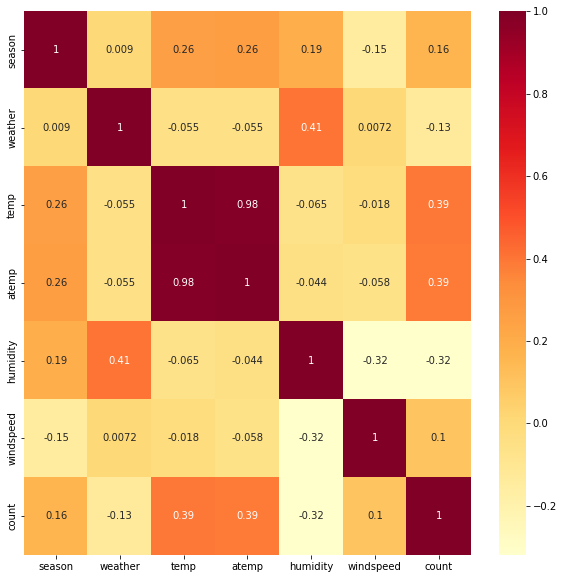

In [184]:
weather_corr = df_train[['season','weather', 'temp', 'atemp','humidity','windspeed','count']].corr()
plt.figure(figsize=(10,10))
sns.heatmap(weather_corr, annot=True, cmap='YlOrRd');

- 타겟인 count 와 상관관계로
- 기온, 체감온도의 상관관계가 높은 것을 확인 할 수 있다

**1 - 3 온도, 풍속, 습도 분석**

In [185]:
#import chart_studio
#chart_studio.tools.set_credentials_file(username='username', api_key='api_key')
#import plotly.graph_objects as go
#from plotly.offline import iplot, init_notebook_mode

In [186]:
#def configure_plotly_browser_state():
#  import IPython
#  display(IPython.core.display.HTML('''
#        <script src="/static/components/requirejs/require.js"></script>
#        <script>
#          requirejs.config({
#            paths: {
#              base: '/static/base',
#              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
#            },
#          });
#        </script>
#        '''))

In [187]:
#configure_plotly_browser_state()
#init_notebook_mode(connected=False)

In [188]:
df_all.loc[ df_all['windspeed'] <= 5, 'windspeed_category'] = 0
df_all.loc[(df_all['windspeed'] > 5) & (df_all['windspeed'] <= 10), 'windspeed_category'] = 1
df_all.loc[(df_all['windspeed'] > 10) & (df_all['windspeed'] <= 15), 'windspeed_category'] = 2
df_all.loc[(df_all['windspeed'] > 15) & (df_all['windspeed'] <= 20), 'windspeed_category'] = 3
df_all.loc[(df_all['windspeed'] > 20) & (df_all['windspeed'] <= 25), 'windspeed_category'] = 4
df_all.loc[(df_all['windspeed'] > 25) & (df_all['windspeed'] <= 30), 'windspeed_category'] = 5
df_all.loc[(df_all['windspeed'] > 30) & (df_all['windspeed'] <= 35), 'windspeed_category'] = 6
df_all.loc[(df_all['windspeed'] > 35) & (df_all['windspeed'] <= 40), 'windspeed_category'] = 7
df_all.loc[(df_all['windspeed'] > 35) & (df_all['windspeed'] <= 40), 'windspeed_category'] = 8
df_all.loc[(df_all['windspeed'] > 40) & (df_all['windspeed'] <= 45), 'windspeed_category'] = 9
df_all.loc[(df_all['windspeed'] > 45) & (df_all['windspeed'] <= 50), 'windspeed_category'] = 10
df_all.loc[ df_all['windspeed'] > 50, 'windspeed_category'] = 11

df_temp_count = df_all.groupby('windspeed_category').sum()

In [189]:
fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_count.index, y=df_temp_count['count'], text=df_temp_count['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({ 
        "title": { "text": "<b>windspeed VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'ggplot2'            
})
fig.show(renderer="colab")

- 풍속 5 단위로 증가하는 그래프
- 0 ~ 3은 풍속 때문에 빌린 대여 수가 증가 했다고는 볼 수 없다
- 풍속 20 부터는 자전거 대여 수가 급격하게 줄어드는 것을 확인 할 수 있다

In [190]:
df_all.loc[ df_all['temp'] <= 5, 'temp_category'] = 0
df_all.loc[(df_all['temp'] > 5) & (df_all['temp'] <= 10), 'temp_category'] = 1
df_all.loc[(df_all['temp'] > 10) & (df_all['temp'] <= 15), 'temp_category'] = 2
df_all.loc[(df_all['temp'] > 15) & (df_all['temp'] <= 20), 'temp_category'] = 3
df_all.loc[(df_all['temp'] > 20) & (df_all['temp'] <= 25), 'temp_category'] = 4
df_all.loc[(df_all['temp'] > 25) & (df_all['temp'] <= 30), 'temp_category'] = 5
df_all.loc[(df_all['temp'] > 30) & (df_all['temp'] <= 35), 'temp_category'] = 6
df_all.loc[(df_all['temp'] > 35) & (df_all['temp'] <= 40), 'temp_category'] = 7
df_all.loc[ df_all['temp'] > 40, 'temp_category'] = 8

df_temp_count = df_all.groupby('temp_category').sum()

In [191]:
fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_count.index, y=df_temp_count['count'], text=df_temp_count['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({ 
        "title": { "text": "<b>temperature VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'ggplot2'            
})
fig.show()

- 온도를 5 단위로 대여 수를 확인하는 그래프
- 10도 이하로는 춥기 때문에 자전거 대여 수가 줄어들고
- 35도 이상일 때는 덥기 때문에 대여 수가 줄어든 것으로 보임

In [192]:
df_all.loc[ df_all['humidity'] <= 10, 'humidity_category'] = 0
df_all.loc[(df_all['humidity'] > 10) & (df_all['humidity'] <= 20), 'humidity_category'] = 1
df_all.loc[(df_all['humidity'] > 20) & (df_all['humidity'] <= 30), 'humidity_category'] = 2
df_all.loc[(df_all['humidity'] > 30) & (df_all['humidity'] <= 40), 'humidity_category'] = 3
df_all.loc[(df_all['humidity'] > 40) & (df_all['humidity'] <= 50), 'humidity_category'] = 4
df_all.loc[(df_all['humidity'] > 50) & (df_all['humidity'] <= 60), 'humidity_category'] = 5
df_all.loc[(df_all['humidity'] > 60) & (df_all['humidity'] <= 70), 'humidity_category'] = 6
df_all.loc[(df_all['humidity'] > 70) & (df_all['humidity'] <= 80), 'humidity_category'] = 7
df_all.loc[(df_all['humidity'] > 80) & (df_all['humidity'] <= 90), 'humidity_category'] = 8
df_all.loc[ df_all['humidity'] > 90, 'humidity_category'] = 9

df_temp_count = df_all.groupby('humidity_category').sum()

In [193]:
fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_count.index, y=df_temp_count['count'], text=df_temp_count['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({ 
        "title": { "text": "<b>humidity VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'ggplot2'            
})
fig.show()

- 습도를 10 단위로 나타낸 그래프
- 20 부터 60까지의 대여수가 많음
- 0 부터 20은 겨울이라 생각되고 따라서 대여 수가 적은 것으로 보임
- 70 부터 대여 수가 적어지는 이유는 비 때문이라고 생각 

In [194]:
df_temp_count = df_all.groupby(['temp_category', 'windspeed_category']).sum()

풍속과 온도를 그룹핑해서 시각화

In [195]:
fig = go.Figure()

for index in range(9):
    fig.add_trace(
        go.Bar( x=df_temp_count.loc[index].index, y=df_temp_count.loc[index]['count'], name="temperature " + str(index) )
    )

fig.update_layout({ 
        "title": { "text": "<b>temperature & windspeed VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1", "title": "windspeed" },
        "barmode": "stack",
        "template":'ggplot2'            
})
fig.show()

- 풍속을 기준으로 각 온도별 대여수를 나타낸 그래프
- 온도는 5씩 증가한다
- 주로 온도가 10도부터 30도 까지 주로 빌리는 것을 확인 할 수 있고
- 위에서 본 것과 같이 풍속이 20을 넘기면서 자전거 대여 수가 확 줄어든 것을 볼 수 있다


온도와 습도를 그룹핑하여 시각화

In [196]:
df_temp_count = df_all.groupby(['temp_category', 'humidity_category']).sum()

In [197]:
fig = go.Figure()

for index in range(9):
    fig.add_trace(
        go.Bar( x=df_temp_count.loc[index].index, y=df_temp_count.loc[index]['count'], name="temperature " + str(index) )
    )

fig.update_layout({ 
        "title": { "text": "<b>temperature & humidity VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "barmode": "stack",
        "template":'ggplot2'            
})
fig.show()

- 습도를 기준으로 온도별 대여수를 나타내는 그래프
- 습도는 10씩 증가한다

1 - 4 날씨 분석

 - 1: 맑음, 구름 적음, 부분적으로 흐림, 부분적으로 흐림
 - 2: 흐림, 안개
 - 3: 옅은 눈, 옅은 비
 - 4: 폭우, 우박, 뇌우

In [198]:
df_temp_count = df_train.groupby(['weather']).sum()

In [199]:
fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_count.index, y=df_temp_count['count'], text=df_temp_count['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({ 
        "title": { "text": "<b>weather VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'ggplot2'            
})
fig.show()

- 보통 맑은 날에 많이 빌림
- 흐린 날에도 빌리긴 하지만 맑은 날에 비해 많이 줄어듬
- 비나 눈이 내리는 날은 대여 회수가 많이 줄어든 것이 확인됨
- 폭우나 우박, 천둥이 쳐도 빌리는 사람이 있긴 함

1 - 5 계절 분석

In [200]:
df_temp_count = df_train.groupby(['season']).sum()

In [201]:
fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_count.index, y=df_temp_count['count'], text=df_temp_count['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({ 
        "title": { "text": "<b>season VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'ggplot2'            
})
fig.show()

- 겨울에 대여 수가 줄은 것을 볼 수 있다

In [202]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_log,registered_log,count_log,date,day,month,year,hour,dow,woy
datetime,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,1.386294,2.639057,2.833213,2011-01-01,1,1,2011,0,5,52
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2.197225,3.496508,3.713572,2011-01-01,1,1,2011,1,5,52
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,1.791759,3.332205,3.496508,2011-01-01,1,1,2011,2,5,52
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,1.386294,2.397895,2.639057,2011-01-01,1,1,2011,3,5,52
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,0.000000,0.693147,0.693147,2011-01-01,1,1,2011,4,5,52


In [203]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_log,registered_log,count_log,date,day,month,year,hour,dow,woy
datetime,,,,,,,,,,,,,,,,,,,,,,
2011-01-20 00:00:00,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-20,20,1,2011,0,3,3
2011-01-20 01:00:00,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-20,20,1,2011,1,3,3
2011-01-20 02:00:00,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-20,20,1,2011,2,3,3
2011-01-20 03:00:00,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-20,20,1,2011,3,3,3
2011-01-20 04:00:00,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-20,20,1,2011,4,3,3


데이터 누수 방지를 위해 테스트 데이터에 없는 컬럼 삭제

In [204]:
df_test = df_test.drop(['casual', 'registered', 'count', 'casual_log', 'registered_log', 'count_log'], axis=1)

> peak, 온도, 풍속, 습도, 날씨 기반 필드 추가

In [205]:
def func(df_data):
    if df_data['workingday'] == 1:
        if (df_data['hour'] == 8) or (df_data['hour'] == 17) or (df_data['hour'] == 18):
            return 4
        elif (df_data['hour'] == 7) or (df_data['hour'] == 16) or (df_data['hour'] == 19): 
            return 3           
    else:
        if (df_data['hour'] >= 12 and df_data['hour'] <= 16):
            return 2
        elif (df_data['hour'] >= 10 and df_data['hour'] <= 19):
            return 1
    return 0

df_all['peak'] = df_all.apply(func, axis=1)

In [206]:
def func(df_data):
    if (df_data['month'] == 12) and (df_data['day'] == 24 or df_data['day'] == 31):
            return 1
    return df_data['holiday']

df_all['holiday'] = df_all.apply(func, axis=1)

In [207]:
def func(df_data):
    if (df_data['month'] == 12) and (df_data['day'] == 24 or df_data['day'] == 31):
            return 0
    return df_data['workingday']

df_all['workingday'] = df_all.apply(func, axis=1)

In [208]:
def func(df_data):
    if (df_data['weather'] <= 2 and df_data['windspeed'] <= 20):
        if (df_data['temp'] > 15 and df_data['temp'] <= 35):
            return 1
    return 0

df_all['fit'] = df_all.apply(func, axis=1)

In [209]:
def func(df_data):
    if df_data['humidity'] >= 70:
            return 1
    return 0

df_all['humid'] = df_all.apply(func, axis=1)

In [210]:
from sklearn.metrics import make_scorer

def get_rmsle(y_actual, y_pred):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

In [211]:
df_all = df_all.drop(['date'], axis=1)

In [212]:
df_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_log,registered_log,count_log,day,month,year,hour,dow,woy,windspeed_category,temp_category,humidity_category,peak,fit,humid
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,1.386294,2.639057,2.833213,1,1,2011,0,5,52,0.0,1.0,8.0,0,0,1
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,2.197225,3.496508,3.713572,1,1,2011,1,5,52,0.0,1.0,7.0,0,0,1
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,1.791759,3.332205,3.496508,1,1,2011,2,5,52,0.0,1.0,7.0,0,0,1
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,1.386294,2.397895,2.639057,1,1,2011,3,5,52,0.0,1.0,7.0,0,0,1
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,0.000000,0.693147,0.693147,1,1,2011,4,5,52,0.0,1.0,7.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,1,0,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,NaN,NaN,NaN,31,12,2012,19,0,1,2.0,2.0,5.0,3,0,0
2012-12-31 20:00:00,2012-12-31 20:00:00,1,1,0,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,NaN,NaN,NaN,31,12,2012,20,0,1,2.0,2.0,5.0,0,0,0
2012-12-31 21:00:00,2012-12-31 21:00:00,1,1,0,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,NaN,NaN,NaN,31,12,2012,21,0,1,2.0,2.0,5.0,0,0,0


In [213]:
df_test['peak'] = df_all['peak']
df_test['fit'] = df_all['fit']
df_test['humid'] = df_all['humid']
df_train['peak'] = df_all['peak']
df_train['fit'] = df_all['fit']
df_train['humid'] = df_all['humid']


In [214]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_log,registered_log,count_log,date,day,month,year,hour,dow,woy,peak,fit,humid
datetime,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,1.386294,2.639057,2.833213,2011-01-01,1,1,2011,0,5,52,0,0,1
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2.197225,3.496508,3.713572,2011-01-01,1,1,2011,1,5,52,0,0,1
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,1.791759,3.332205,3.496508,2011-01-01,1,1,2011,2,5,52,0,0,1
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,1.386294,2.397895,2.639057,2011-01-01,1,1,2011,3,5,52,0,0,1
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,0.000000,0.693147,0.693147,2011-01-01,1,1,2011,4,5,52,0,0,1


# 기본 모델링

In [215]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df_train, test_size=0.2, random_state=5)

In [216]:
target = 'count_log'
features = ['season', 'holiday', 'workingday', 'weather', 'temp',
    'atemp', 'humidity', 'windspeed', 'day', 'month',
    'year', 'hour', 'dow', 'woy', 'peak', 'fit', 'humid']

y_train = train[target]
X_train = train[features]

X_val = val[features]
y_val = val[target]

X_test = df_test[features]

In [217]:
X_train.shape, X_val.shape, X_test.shape

((8708, 17), (2177, 17), (6493, 17))

/

**baseline model**

/

In [218]:
bs_predict= [y_train.mean()] * len(X_val)

In [219]:
from sklearn.metrics import mean_squared_error, r2_score

bs_mae = np.sqrt(mean_squared_log_error(y_val, bs_predict))
bs_r2 = r2_score(y_val, bs_predict)

print('검증값','','R2:', bs_r2, ' rmsle:',bs_mae )

검증값  R2: -0.00023243835646491462  rmsle: 0.31890908554252895


# **LinearRegression**

In [220]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

y_lr_pred = lr_model.predict(X_val)

lr_rmsle = np.sqrt(mean_squared_log_error(y_val, y_lr_pred))
lr_r2 = r2_score(y_val, y_lr_pred)

print('rmsle:', lr_rmsle)
print('r2:', lr_r2)

rmsle: 0.20786446554585108
r2: 0.6328016224283362


In [221]:
coef = pd.Series(lr_model.coef_, X_test.columns)
coef

season       -0.017673
holiday       0.108913
workingday   -0.088875
weather       0.008140
temp          0.009546
atemp         0.024120
humidity     -0.010448
windspeed     0.003257
day           0.003340
month         0.092148
year          0.429481
hour          0.084071
dow           0.028187
woy          -0.007227
peak          0.404513
fit           0.184698
humid        -0.073659
dtype: float64

In [222]:
y_lr_test = lr_model.predict(X_test)
submission['count'] = np.expm1(y_lr_test)
submission.to_csv("submission.csv", index=False)

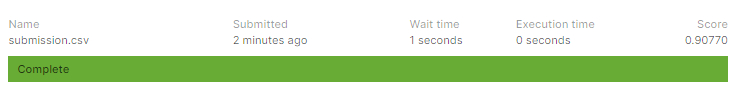

Score 점수가 낮을 수록 높은 순위...

# SelectKBest 모듈 활용하여 변수 선택(feature selecting)



feature 수:  1
Selected names: Index(['hour'], dtype='object')
Test MAE: $1
Test R2: 0.3173752443039952 

feature 수:  2
Selected names: Index(['hour', 'peak'], dtype='object')
Test MAE: $1
Test R2: 0.48787964998150746 

feature 수:  3
Selected names: Index(['temp', 'hour', 'peak'], dtype='object')
Test MAE: $1
Test R2: 0.5616766145365314 

feature 수:  4
Selected names: Index(['temp', 'atemp', 'hour', 'peak'], dtype='object')
Test MAE: $1
Test R2: 0.5631351194830887 

feature 수:  5
Selected names: Index(['temp', 'atemp', 'humidity', 'hour', 'peak'], dtype='object')
Test MAE: $1
Test R2: 0.5779929400072324 

feature 수:  6
Selected names: Index(['temp', 'atemp', 'humidity', 'hour', 'peak', 'humid'], dtype='object')
Test MAE: $1
Test R2: 0.5790186046520045 

feature 수:  7
Selected names: Index(['temp', 'atemp', 'humidity', 'hour', 'peak', 'fit', 'humid'], dtype='object')
Test MAE: $1
Test R2: 0.5835541284711505 

feature 수:  8
Selected names: Index(['temp', 'atemp', 'humidity', 'year', 'hour

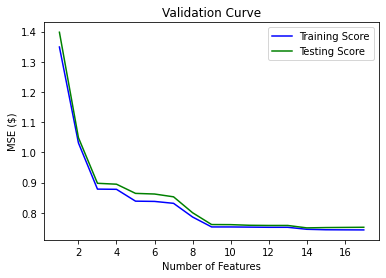

In [223]:
from sklearn.feature_selection import f_regression, SelectKBest

training = []
testing = []

ks = range(1, len(X_train.columns)+1)

for k in range(1, len(X_train.columns)+1):
    print('feature 수: ', k)

    selector = SelectKBest(score_func=f_regression, k=k)

    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)

    all_names = X_train.columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names:', selected_names)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_train_selected)
    mse = mean_squared_error(y_train, y_pred)
    training.append(mse)

    y_pred = model.predict(X_val_selected)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    testing.append(mse)
    print(f'Test MAE: ${mse:,.0f}')
    print(f'Test R2: {r2} \n')

plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MSE ($)")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()

In [224]:
selector = SelectKBest(score_func=f_regression, k=14)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_train_selected.shape

((8708, 14), (8708, 14))

In [225]:
all_names = X_train.columns
## selector.get_support()
selected_mask = selector.get_support()
## 선택된 특성(변수)들
selected_names = all_names[selected_mask]
## 선택되지 않은 특성(변수)들
unselected_names = all_names[~selected_mask]
print('선택된 특성들 : ', selected_names)
print('선택되지 않은 특성들 : ', unselected_names)

선택된 특성들 :  Index(['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month',
       'year', 'hour', 'dow', 'woy', 'peak', 'fit', 'humid'],
      dtype='object')
선택되지 않은 특성들 :  Index(['holiday', 'workingday', 'day'], dtype='object')


> 'season', 'temp', 'atemp', 'humidity', 'month', 'year', 'hour', 'peak',
       'fit', 'humid' 피쳐들이 가장 높은 상관관계를 가지고 있음

In [226]:
target = 'count_log'
features = ['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month',
       'year', 'hour', 'dow', 'woy', 'peak', 'fit', 'humid']

y_train = train[target]
X_train = train[features]

X_val = val[features]
y_val = val[target]

X_test = df_test[features]

In [227]:
X_train

,season,weather,temp,atemp,humidity,windspeed,month,year,hour,dow,woy,peak,fit,humid
datetime,,,,,,,,,,,,,,
2012-12-18 12:00:00,4,3,19.68,23.485,48,16.9979,12,2012,12,1,51,0,0,0
2011-07-14 22:00:00,3,1,26.24,31.060,57,6.0032,7,2011,22,3,28,0,1,0
2011-11-04 23:00:00,4,1,13.12,15.150,49,22.0028,11,2011,23,4,44,0,0,0
2012-07-19 14:00:00,3,1,35.26,39.395,44,6.0032,7,2012,14,3,29,0,0,0
2012-08-18 07:00:00,3,1,24.60,28.030,83,15.0013,8,2012,7,5,33,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-07-15 20:00:00,3,1,28.70,32.575,51,15.0013,7,2011,20,4,28,0,1,0
2012-10-17 14:00:00,4,2,22.96,26.515,43,11.0014,10,2012,14,2,42,0,1,0
2011-10-02 00:00:00,4,3,14.76,16.665,93,19.9995,10,2011,0,6,39,0,0,1


# Ridge 

In [228]:
rg_model = Ridge()
rg_model.fit(X_train, y_train)
y_rg_pred = rg_model.predict(X_val)

rg_mse = np.sqrt(mean_squared_error(y_val, y_rg_pred))
rg_r2 = r2_score(y_val, y_rg_pred)

print('rmsle:', rg_mse)
print('r2:', rg_r2)

rmsle: 0.8659510004140933
r2: 0.6337717344981769


In [229]:
alphas = np.arange(0, 1, 0.01)

rgcv_model = RidgeCV(alphas=alphas, cv=5)
rgcv_model.fit(X_train, y_train)

y_rgcv_pred = rgcv_model.predict(X_val)

rgcv_mse = mean_squared_error(y_val, y_rgcv_pred)
rgcv_r2 = r2_score(y_val, y_rgcv_pred)

print('rmsle:', rgcv_mse)
print('r2:', rgcv_r2)
print(f'alpha: {rgcv_model.alpha_}')

rmsle: 0.7498710238594362
r2: 0.6337717888356369
alpha: 0.99


In [230]:
pipe_rg = make_pipeline(
    SimpleImputer(strategy='median'),
    RidgeCV(alphas=0.99)
)

scores = cross_val_score(pipe_rg, X_train, y_train, cv=5, scoring='r2')

In [231]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def RidgeCVRegression(degree=3, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), RidgeCV(**kwargs))

alphas = np.arange(0, 10, 0.02)

model_rgcv = RidgeCVRegression(alphas=alphas, normalize=True, cv=5)
model_rgcv.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridgecv',
                 RidgeCV(alphas=array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76,...
       8.8 , 8.82, 8.84, 8.86, 8.88, 8.9 , 8.92, 8.94, 8.96, 8.98, 9.  ,
       9.02, 9.04, 9.06, 9.08, 9.1 , 9.12, 9.14, 9.16, 9.18, 9.2 , 9.22,
       9.24, 9.26, 9.28, 9.3 , 9.32, 9.34, 9.36, 9.38, 9.4 , 9.42, 9.44,
       9.46, 9.48, 9.5 , 9.52, 9.54, 9.56, 9.58, 9.6 , 9.62, 9.64, 9.66,
       9.68, 9.7 , 9.72, 9.74, 9.76, 9.78, 9.8 , 9.82, 9.84, 9.86, 9.88,
       9.9 , 9.92, 9.94, 9.96, 9.98]),
                         cv=5, fit_intercept=True, gcv_mode=None,
      

In [233]:
y_pred_rgcv = model_rgcv.predict(X_val)

mse_rgcv = mean_squared_error(y_val, y_pred_rgcv)
r2_rgcv = r2_score(y_val, y_pred_rgcv)
print(f'Test mse: {mse_rgcv:,.0f}')
print(f'R2 Score: {r2_rgcv:,.6f}\n')
print(f'alpha: {model_rgcv.named_steps["ridgecv"].alpha_}')

Test mse: 0
R2 Score: 0.763194

alpha: 0.02


In [234]:
X_test = X_test[['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month',
       'year', 'hour', 'dow', 'woy', 'peak', 'fit', 'humid']]
y_rgcv_test = model_rgcv.predict(X_test)
submission['count'] = np.expm1(y_rgcv_test)
submission.to_csv("submission.csv", index=False)

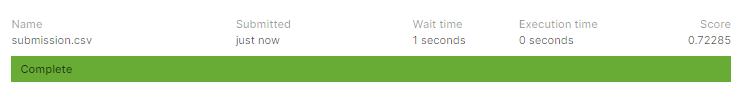

LinearRegression으로 그냥 돌렸을 때 보다는 확실하게 많이 줄어들었다~

# Random Forest Regressor

In [235]:
rf_model = RandomForestRegressor(n_jobs=-1, random_state=5)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_val)

rf_mse = mean_squared_error(y_val, y_rf_pred)
rf_r2 = r2_score(y_val, y_rf_pred)

print('rmsle:', rf_mse)
print('r2:', rf_r2)

rmsle: 0.10300697697369372
r2: 0.9496926008417202


In [236]:
pipe_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_jobs=-1, random_state=5)
)

pipe_rf.fit(X_train, y_train)

y_prf_pred = pipe_rf.predict(X_val)

prf_mse = mean_squared_log_error(y_val, y_prf_pred)
prf_r2 = r2_score(y_val, y_prf_pred)

print('rmsle:', prf_mse)
print('r2:', prf_r2)

rmsle: 0.007717076620195443
r2: 0.9496926008417202


In [237]:
dists = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': range(50, 300, 50), 
    'randomforestregressor__max_depth': range(1,20,2), 
    'randomforestregressor__max_features': range(1,11,1) 
}

rf_reg_rcv = RandomizedSearchCV(
    pipe_rf,
    param_distributions=dists,
    n_iter=10,
    cv=5,
    scoring='r2',
    verbose=1,
)

rf_reg_rcv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=[],
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=[],
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,
    

In [238]:
print('Best Parameters: ', rf_reg_rcv.best_params_)
print('R2: ', rf_reg_rcv.best_score_)

Best Parameters:  {'simpleimputer__strategy': 'mean', 'randomforestregressor__n_estimators': 250, 'randomforestregressor__max_features': 5, 'randomforestregressor__max_depth': 15}
R2:  0.9420480321320099


In [239]:
best_rf_pipe = rf_reg_rcv.best_estimator_

y_best_rf_pred = best_rf_pipe.predict(X_val)
r2_best_rf=r2_score(y_val, y_best_rf_pred)

print('R2:', r2_best_rf)

R2: 0.9454457908321995


In [240]:
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

pipe_rf_fin = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_jobs=-1, n_estimators=100, max_depth = 13, max_features=8, random_state=5)
)

pipe_rf_fin.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=13,
                                       max_features=8, max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=

In [241]:
y_pred_rf_fin = pipe_rf_fin.predict(X_test)
submission['count'] = np.expm1(y_pred_rf_fin)
submission.to_csv("submission.csv", index=False)

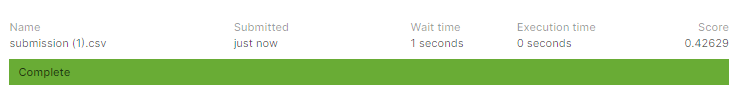

굉장히 많이 줄어들었다~

# XGBoost

In [242]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state =5)

In [243]:
xg_model = XGBRegressor()
xg_model.fit(X_train, y_train)
y_xg_pred = xg_model.predict(X_val)

xg_mse = mean_squared_error(y_val, y_rf_pred)
xg_r2 = r2_score(y_val, y_xg_pred)

print('rmsle:', xg_mse)
print('r2:', xg_r2)

[03:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmsle: 3.782492776044495
r2: 0.9370831612207148


In [244]:
pipe_xgb= make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBRegressor(n_estimators=100,
                 random_state=5,
                 n_jobs=-1,
                 max_depth=13,
                 learning_rate=0.2)
)
xgb_grid = pipe_xgb
pipe_xgb.fit(X_train, y_train)

[03:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster=...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.2,
                              max_delta_step=0, max_depth=13,
                              min_child_weight=1, missing=None,
                              n_estimators=100, n_jobs=-1, nthread=None,
        

In [245]:
y_xgb_pred = pipe_xgb.predict(X_val)

xgb_mse = mean_squared_log_error(y_val, y_xgb_pred)
xgb_r2 = r2_score(y_val, y_xgb_pred)

print('mse:', xgb_mse)
print('r2:', xgb_r2)

mse: 0.007589290656763492
r2: 0.9523527620703346


In [246]:
y_xgb_test = pipe_xgb.predict(X_test)
submission['count'] = np.expm1(y_xgb_test)
submission.to_csv("submission.csv", index=False)

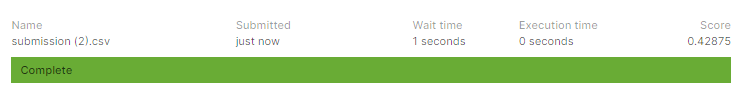

오히려 늘어났다

# Gradient Boosting Regressor

In [247]:
def predict_bikecount(model, select_columns):
    df_train, df_test = split_df(df_all)

    X_train = df_train[select_columns]
    y_train_cas = df_train['casual_log']
    y_train_reg = df_train['registered_log']
    X_test = df_test[select_columns]
    
    casual_model = model.fit(X_train, y_train_cas)
    y_pred_cas = casual_model.predict(X_test)
    y_pred_cas = np.exp(y_pred_cas) - 1

    registered_model = model.fit(X_train, y_train_reg)
    y_pred_reg = registered_model.predict(X_test)
    y_pred_reg = np.exp(y_pred_reg) - 1

    return y_pred_cas + y_pred_reg

In [248]:
gradientboost_columns = [
    'season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month',
       'year', 'hour', 'dow', 'woy', 'peak', 'fit', 'humid'
]

In [249]:
rmsle_scorer = make_scorer(get_rmsle, greater_is_better=False)

n_estimators = [100]
max_depth = [13]
min_samples_leaf = [15]
learning_rate = [0.02, 0.05, 0.1]
subsample = [0.6, 0.7, 0.8]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 
                    'min_samples_leaf': min_samples_leaf,
                    'learning_rate': learning_rate, 'subsample': subsample
              }

gb_grid=GridSearchCV(estimator = GradientBoostingRegressor(), param_grid = hyperparams, 
                verbose=True, scoring=rmsle_scorer, cv=5, n_jobs=-1)

gb_grid.fit(X_train, y_train)
print(gb_grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished


{'learning_rate': 0.1, 'max_depth': 13, 'min_samples_leaf': 15, 'n_estimators': 100, 'subsample': 0.8}


In [250]:
gb_model = gb_grid.best_estimator_
ml_pred = predict_bikecount(gb_model, gradientboost_columns)
df_test['count'] = ml_pred
submission = df_test[['datetime', 'count']].copy()
submission.to_csv('submission.csv', header=True, index=False)

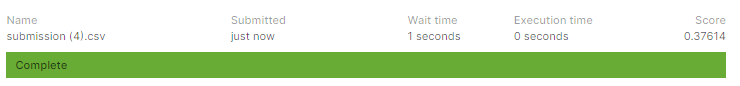

점점 좋아지고 있다

# Random Forest + Gradient Boost

In [251]:
randomforest_columns = [
    'weather', 'temp', 'atemp', 'windspeed', 'workingday', 'season', 'holiday', 'hour', 'dow', 
    'humid', 'woy', 'peak'
]
gradientboost_columns = [
    'weather', 'temp', 'atemp', 'windspeed', 'workingday', 'season', 'holiday', 'hour', 'dow',
    'humidity', 'fit', 'year'
]

In [252]:
randomforest_model = rf_reg_rcv.best_estimator_
gradientboost_model = gb_grid.best_estimator_

randomforest_pred = predict_bikecount(randomforest_model, randomforest_columns)
gradientboost_pred = predict_bikecount(gradientboost_model, gradientboost_columns)
y_pred = np.round(0.2 * randomforest_pred + 0.8 * gradientboost_pred)
df_test['count'] = y_pred
submission = df_test[['datetime', 'count']].copy()
submission.to_csv('submission.csv', header=True, index=False)

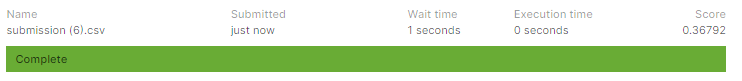

# RandomForest + XGBoost

In [253]:
xgb_grid = GridSearchCV(estimator = XGBRegressor(), param_grid = hyperparams, 
                verbose=True, scoring=rmsle_scorer, cv=5, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

randomforest_columns = [
    'weather', 'temp', 'atemp', 'windspeed', 'workingday', 'season', 'holiday', 'hour', 'dow', 
    'humid', 'woy', 'peak'
]
xgboost_columns = [
    'weather', 'temp', 'atemp', 'windspeed', 'workingday', 'season', 'holiday', 'hour', 'dow',
    'humidity', 'fit', 'year'
]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.4min finished


[03:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [254]:
randomforest_model = rf_reg_rcv.best_estimator_
xgb_model = xgb_grid.best_estimator_
randomforest_pred = predict_bikecount(randomforest_model, randomforest_columns)
xgboost_pred = predict_bikecount(xgb_model, xgboost_columns)
y_pred = np.round(0.2 * randomforest_pred + 0.8 * xgboost_pred)
df_test['count'] = y_pred
submission = df_test[['datetime', 'count']].copy()
submission.to_csv('submission.csv', header=True, index=False)


[03:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


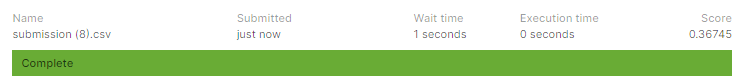

마지막.. 0.36745

# SHAP

In [255]:
sh_features = ['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month',
       'year', 'hour', 'dow', 'woy', 'fit', 'humid']
sh_target = 'count_log'

X_train_sh = X_train[sh_features]
X_val_sh = X_val[sh_features]

In [256]:
row = X_val.iloc[[0]]
row

,season,weather,temp,atemp,humidity,windspeed,month,year,hour,dow,woy,peak,fit,humid
datetime,,,,,,,,,,,,,,
2012-11-16 10:00:00,4,1,13.94,16.665,53,12.998,11,2012,10,4,46,0,0,0


In [257]:
rf_model.predict(row)

array([5.27762916])

In [258]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

In [259]:
shap.initjs()
shap_values = explainer.shap_values(X_val.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, X_val.iloc[:100])

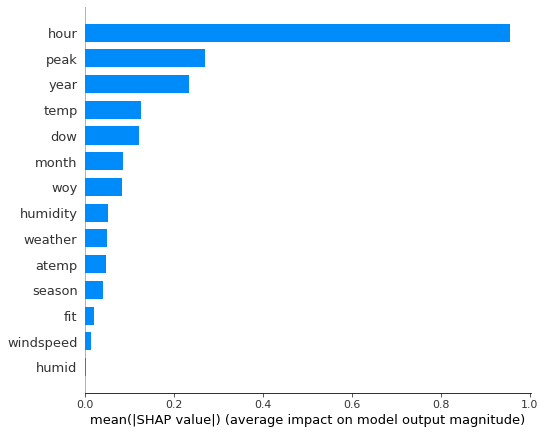

In [260]:
shap_values = explainer.shap_values(X_val.iloc[:300])
shap.summary_plot(shap_values, X_val.iloc[:300], plot_type='bar')